In [53]:
import numpy as np
from astropy import wcs
from astropy.io import fits
import sys
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.colors as colors

path = '/Users/alexgagliano/Documents/Research/2020oi/data/difference_images/'
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]

ra_20oi = 185.728875
dec_20oi = +15.8236

In [54]:
file_photometry_g = {}
file_photometry_r = {}
file_photometry_i = {}
file_photometry_z = {}

g_dates = []
r_dates = []
i_dates = []
z_dates = []

#5 arcsec (assuming ps1) 0.25''/pix --> 
rad = 5/0.2496 #in px
#so a circle of 20 pixels around x, y

for filename in onlyfiles:
#filename = '2020oi.g.200128_2205790_1635.091_g.18581117_3796104_1635.091.diff.fits'
    fn = path + filename
    band = fn.split("/")[-1].split(".")[1]
    uniqueID = fn.split("/")[-1].split(".")[4]
    hdulist = fits.open(fn)
    w = wcs.WCS(hdulist[0].header)
    image_data = hdulist[0].data
    #ZP = hdulist[0].header['ZP']
    #mag_data = -2.5*np.log10(image_data) + g_ZP

    x, y = w.wcs_world2pix(ra_20oi, dec_20oi,1, ra_dec_order=True)   

    #from here: https://math.stackexchange.com/questions/1015199/equidistant-points-on-a-circle
    #trying: 
    Npts = 20
    theta = 2*np.pi/Npts
    x_arr = []
    y_arr = []
    for k in np.arange(Npts):
        x_arr.append(rad*np.cos(k*theta)+x)
        y_arr.append(rad*np.sin(k*theta)+y)
        
    ra_arr, dec_arr = w.all_pix2world(x_arr, y_arr, 1)
    
    positions = [x_arr, y_arr]
    aperture = CircularAperture(positions, r=2)
    
    phot_table = aperture_photometry(image_data, aperture)
    #phot_table['aperture_sum'].info.format = '%.8g'  # for consistent table output
    phot_df = phot_table.to_pandas()
    date = hdulist[0].header['DATE-OBS']
    if band == 'g':
        file_photometry_g[filename] = phot_df
        g_dates.append(date)
    elif band == 'r':
        file_photometry_r[filename] = phot_df
        r_dates.append(date)
    elif band == 'i':
        file_photometry_i[filename] = phot_df
        i_dates.append(date)
    elif band == 'z':
        file_photometry_z[filename] = phot_df
        z_dates.append(date)
        
    #write to regions file for plotting later
    #open image
    #write in the format
    f = open("%s_apertures.reg"%fn, "w")
    for i in np.arange(len(x_arr)):
        f.write("image;circle(%.3f,%.3f,2) # color=blue\n" % (x_arr[i], y_arr[i]))
    f.write("image;circle(%.3f,%.3f,2) # color=red\n" % (x, y)) #mark the location of 20oi
    f.close()

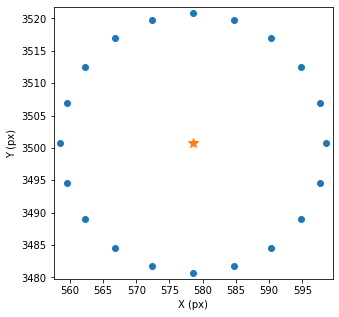

In [18]:
plt.figure(figsize=(5, 5))
plt.plot(x_arr, y_arr, 'o', label='forced phot points')
plt.plot(x, y, '*', label='SN 2020oi', ms=10)
plt.xlim((x-21, x+21))
plt.ylim((y-21, y+21))
plt.xlabel("X (px)");
plt.ylabel("Y (px)");
plt.savefig("/Users/alexgagliano/Documents/Research/2020oi/forcedPhotometry.png", dpi=200)

In [19]:
import numpy as np
from astropy import units as u
from astropy.coordinates import SkyCoord
from photutils import CircularAperture
from photutils import aperture_photometry

c1 = SkyCoord(ra_20oi*u.deg, dec_20oi*u.deg, frame='icrs')
for i in np.arange(len(ra_arr)):
    c2 = SkyCoord(ra_arr[i]*u.deg,dec_arr[i]*u.deg, frame='icrs')
    print(c1.separation(c2).arcsec)

5.001677192554557
5.0029042039130065
5.003536283104912
5.0033317939836035
5.002368307185933
5.00101313189196
4.999783457650967
4.999148970244714
4.9993521518309265
5.000315342797481
5.0016705192514825
5.002900249532079
5.003535436442956
5.003334138206747
5.002373611818071
5.001020876053739
4.999792882322183
4.999159153647171
4.999362098576463
5.000324080581395


In [ ]:
#nice, I'm calling that a win. 

In [61]:
import seaborn as sns
#"scale error with square root of reduced chi squared"
vals = file_photometry_g['2020oi.g.200121_2201158_1635.091_g.18581117_3796104_1635.091.diff.fits']['aperture_sum'].values

In [66]:
np.sum(vals - np.mean(vals))**2/(np.std(vals)**2)

2.4638873201877076e-31

In [86]:
i = 0
#df_temp = pd.DataFrame({'Date':"", 'Band':"",'f':np.nan})
f = []
for value in file_photometry_g.values():
    #print(g_dates[i])
    tempVals = value['aperture_sum'].values
    print(np.sum((tempVals - np.mean(tempVals))**2/np.std(tempVals)**2))
    f.append(np.sqrt(np.sum(tempVals - np.mean(tempVals))**2/(np.std(tempVals)**2)))
#    f.append(np.sqrt(np.sum((value['aperture_sum'].values - np.mean(value['aperture_sum'].values))**2/np.std(value['aperture_sum'].values)**2)))
  #  break
    i+= 1
df_g = pd.DataFrame({'Date': np.array(g_dates), 'Band': np.array(len(g_dates)*['g']), 'f':np.array(f)})

i = 0
#df_temp = pd.DataFrame({'Date':"", 'Band':"",'f':np.nan})
f = []
for value in file_photometry_r.values():
    #print(g_dates[i])
    tempVals = value['aperture_sum'].values
    print(np.sum((tempVals - np.mean(tempVals))**2/np.std(tempVals)**2))
    f.append(np.sqrt(np.sum(tempVals - np.mean(tempVals))**2/(np.std(tempVals)**2)))
#    f.append(np.sqrt(np.sum((value['aperture_sum'].values - np.mean(value['aperture_sum'].values))**2/np.std(value['aperture_sum'].values)**2)))
    i+= 1
df_r = pd.DataFrame({'Date': np.array(r_dates), 'Band': np.array(len(r_dates)*['r']), 'f':np.array(f)})

i = 0
#df_temp = pd.DataFrame({'Date':"", 'Band':"",'f':np.nan})
f = []
for value in file_photometry_i.values():
    #print(g_dates[i])
    tempVals = value['aperture_sum'].values
    print(np.sum((tempVals - np.mean(tempVals))**2/np.std(tempVals)**2))
    f.append(np.sqrt(np.sum(tempVals - np.mean(tempVals))**2/(np.std(tempVals)**2)))
#    f.append(np.sqrt(np.sum((value['aperture_sum'].values - np.mean(value['aperture_sum'].values))**2/np.std(value['aperture_sum'].values)**2)))
    i+= 1
df_i = pd.DataFrame({'Date': np.array(i_dates), 'Band': np.array(len(i_dates)*['i']), 'f':np.array(f)})

i = 0
#df_temp = pd.DataFrame({'Date':"", 'Band':"",'f':np.nan})
f = []
for value in file_photometry_z.values():
    #print(g_dates[i])
    f.append(np.sqrt(np.sum((value['aperture_sum'].values - np.mean(value['aperture_sum'].values))**2/np.std(value['aperture_sum'].values)**2)))
    i+= 1
df_z = pd.DataFrame({'Date': np.array(z_dates), 'Band': np.array(len(z_dates)*['z']), 'f':np.array(f)})


20.0
19.999999999999996
20.000000000000004
nan
20.0
20.000000000000004
20.000000000000004
20.0
nan
nan
nan
nan
19.999999999999996
nan
20.0
nan
nan
nan
nan
20.000000000000004
20.000000000000007
19.999999999999993
19.999999999999996
nan
nan
20.0
20.0
19.999999999999996
20.0
19.999999999999996
nan
19.999999999999996
20.0
20.000000000000004
nan
nan
20.0
nan
20.000000000000004
20.000000000000007
19.999999999999996
nan
20.000000000000007
20.0
nan
nan
19.999999999999996
20.0
nan
nan
20.000000000000004
nan
nan
nan
nan
nan
20.000000000000004
nan


/Users/alexgagliano/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/Users/alexgagliano/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
/Users/alexgagliano/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/Users/alexgagliano/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/Users/alexgagliano/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/Users/alexgagliano/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/Users/alexgagliano/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountere

In [77]:
fullDF = pd.concat([df_g, df_r, df_i, df_z], ignore_index=True)
fullDF.dropna(inplace=True)

In [78]:
len(fullDF[fullDF['Band'] == 'z'])

5

In [79]:
from astropy.time import Time

t = Time([str(x) for x in fullDF['Date'].values], format='isot', scale='utc')
fullDF['MJD'] = t.mjd


In [379]:
fullDF.to_csv("/Users/alexgagliano/Documents/Research/2020oi/data/forcedPhotometry_errorScaling.csv", index=False)

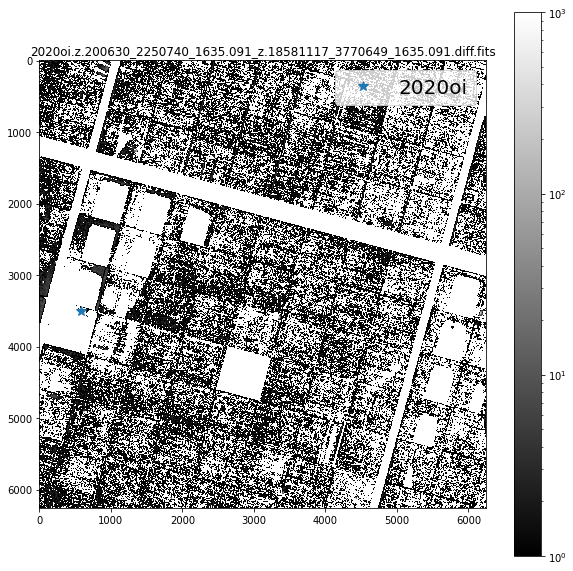

In [380]:
from matplotlib.colors import LogNorm
fig= plt.figure(figsize=(10,10))
a = plt.imshow(image_data, norm=LogNorm(vmax=1.e3), cmap='gray')
plt.plot(x, y, '*', ms=10, label='2020oi')
plt.title("%s"%filename)
fig.colorbar(a);
plt.legend(fontsize=20);